In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importar Librerías

In [25]:
# Librerías Básicas
# ====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Redes Neuronales
# ====================================================
import tensorflow as ts
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam, Adadelta
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

# Métricas y Preprocesado
# ====================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import norm

# Eliminar warnings
# ====================================================
import warnings
warnings.filterwarnings('ignore')

## Cargar Datos

Cargamos datos desde el repositorio de git y lo descomprimimos

In [3]:
!git clone "https://github.com/cienciadatos/niche_fraudsters.git"
!unzip "/content/niche_fraudsters/df_final.zip"

Cloning into 'niche_fraudsters'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 43 (delta 15), reused 31 (delta 6), pack-reused 0
Unpacking objects: 100% (43/43), 14.45 MiB | 8.52 MiB/s, done.
Archive:  /content/niche_fraudsters/df_final.zip
  inflating: df_final_test.csv       
  inflating: df_final_train.csv      


In [4]:
DF_FINAL_TRAIN = "/content/df_final_train.csv"
DF_FINAL_TEST  = "/content/df_final_test.csv"

## Funciones Auxiliares

In [5]:
df_final_train = pd.read_csv(DF_FINAL_TRAIN)
df_final_test = pd.read_csv(DF_FINAL_TEST)

In [6]:
df_final_train.shape, df_final_test.shape

((92790, 16), (23198, 15))

In [75]:
def make_pipeline(df):
    df_autoenc = df.set_index('id')
    std_scaler = StandardScaler()
    df_autoenc_ss = std_scaler.fit_transform(df_autoenc.iloc[:,:-1].to_numpy())
    df_autoenc_ss = pd.DataFrame(df_autoenc_ss, columns=df_autoenc.iloc[:,:-1].columns, index=df_autoenc.index)
    df_autoenc = pd.concat([df_autoenc_ss,df_autoenc.iloc[:,-1]],axis=1)
    return df_autoenc

def print_metrics(Y_test,Y_pred):
    """Imprime métricas básicas de la clasificación.
    """
    metricas = classification_report(Y_test,Y_pred)
    print(metricas)

def print_conf_matrix(Y_test,Y_pred,labels=[0,1]):
    """Plotea la matriz de confusión de la clasificación.
    """
    cm = confusion_matrix(Y_test, Y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=['0','1'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.subplots()[1])
    plt.title('Matriz de Confusión')
    plt.show();


def pr_auc_score(y_true, y_pred_proba, X_test, modelo, version):
    '''Return the area under the Precision-Recall curve.
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for 
        each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier 
        for each observation (first column) and the predicted probabilities 
        estimates for the minority class (second column).
    Returns:float'''
    y_true = pd.DataFrame(y_true).reset_index()
    y_pred_proba = pd.DataFrame(y_pred_proba, index=X_test.index).reset_index()
    y_true_sorted = y_true.sort_values('id')
    y_pred_proba_sorted = y_pred_proba.sort_values('id')
    y_true_sorted = y_true_sorted.reset_index(drop=True)
    y_pred_proba_sorted = y_pred_proba_sorted.reset_index(drop=True)
    pr_auc_score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), 
                                           np.ravel(y_pred_proba_sorted.iloc[:, 1]))
    data = [(modelo, version),('PR AUC',pr_auc_score)]
    model_summary = pd.DataFrame(data, columns=['param','selected'])
    print(model_summary)

def calc_reconstruction_error(X_train, X_pred, X_test, X_pred_te):
    """Obtiene el error de reconstrucción ponderado por los valores de entrenamiento.
    """
    mse_tr = np.mean(np.power(X_train - X_pred, 2), axis=1)
    min_mse = min(mse_tr)
    max_mse = max(mse_tr)
    
    mse = np.mean(np.power(X_test - X_pred_te, 2), axis=1)
    mse = (mse-min_mse) / max_mse
    print(mse)
    
    mse = [1 if e > 1 else e for e in mse]
    print(mse)
    return mse

def print_reconstruction_error(mse, Y_test, threshold):
    """Plotea el error de reconstrucción para las dos clases.
    """
    error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test})
    
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
                label= "Fraud" if name == 1 else "Normal", alpha = 0.9 if name == 1 else 0.1)
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();
    
def pr_auc_score_autoenc(Y_test, mse, X_test, modelo, version):
    """Prepara los datos pasa simular prauc con una medida sintetica"""
    #print(Y_test)
    
    ytrue = pd.Series(Y_test)    
    
    proba = pd.DataFrame(mse)
    proba['id'] = Y_test.index
    
    xtest = pd.DataFrame(X_test)
    
    return pr_auc_score(ytrue, proba, xtest, modelo, version)

def recons_error(X_test, X_pred_te):
    mse = np.mean(np.power(X_test - X_pred_te, 2), axis=1)
    return mse

def recons_euc_error(X_test, X_pred_te):
    euclidean_error = np.linalg.norm(X_test - X_pred_te, axis=1)
    return euclidean_error

def recons_bce_error(X_test, X_pred_te):
    loss_te = ts.keras.losses.binary_crossentropy(X_test,X_pred_te)
    loss_te = loss_te.numpy()
    return loss_te

def probs_clases(rec_error):
    mu = np.mean(rec_error)
    sigma = np.std(rec_error)
    pdf_values = norm.pdf(rec_error, mu, sigma)
    prob_no_fraud = pdf_values / np.sum(pdf_values)
    prob_fraud = 1 - prob_no_fraud
    probs = np.vstack((prob_no_fraud, prob_fraud)).T
    return probs

def sacar_pr_auc_mse(X_test,X_pred_te,Y_test,modelo,version):
    mse = recons_error(X_test, X_pred_te)
    probabs = probs_clases(mse)
    pr_auc_score_autoenc(Y_test, probabs, X_test, modelo, version)

def sacar_pr_auc_euc(X_test,X_pred_te,Y_test,modelo,version):
    euc = recons_euc_error(X_test, X_pred_te)
    probabs = probs_clases(euc)
    pr_auc_score_autoenc(Y_test, probabs, X_test, modelo, version)

def sacar_pr_auc_bse(X_test,X_pred_te,Y_test,modelo,version):
    bse = recons_bce_error(X_test, X_pred_te)
    probabs = probs_clases(bse)
    pr_auc_score_autoenc(Y_test, probabs, X_test, modelo, version)

def out_challenge(X_test, X_pred_te):
    euc = recons_euc_error(X_test, X_pred_te)
    probabs = probs_clases(euc)

def generate_output(X_pred_te, X_test, index_x_test, nombre_version):
    euc = recons_euc_error(X_test, X_pred_te)
    probabs = probs_clases(euc)
    prob_positiva = probabs[:,1]
    print(prob_positiva)
    output = pd.DataFrame({
            "index"      : [x for x in range(len(X_test))],
            "ID"         : index_x_test,
            "fraud_flag" : prob_positiva
    })
    print(output.head())
    output.to_csv(nombre_version + '.csv',sep=",", index=False)

In [42]:
# FUNCIONES PARA AUTOENCODER

def print_distribucion_loss(loss):
    """Calcula distintos puntos de la distribución de loss y 
    los imprime por pantalla.
    """
    print(np.round(np.quantile(loss,0.25),4))
    print(np.round(np.quantile(loss,0.5),4))
    print(np.round(np.quantile(loss,0.75),4))
    print(np.round(np.quantile(loss,0.90),5))
    print(np.round(np.quantile(loss,0.95),5))
    print(np.round(np.quantile(loss,0.99),5))
    print(max(np.round(loss,5)))

def print_boxplot_loss(loss):
    """Plotea un boxplot de la distribución de losses.
    """
    pd.DataFrame(loss).boxplot()

def top_losses(loss, top=10):
    """Saca los losses más elevados.
    """
    lista_losses = sorted([x for x in loss],reverse=True)
    print(lista_losses[:top])

def set_threshold(loss, maxim=True, quant=0.95):
    # ESTABLECER THRESHOLD DE CLASIFICACIÓN
    # =====================================
    # En un autoencoder entrenado con transacciones normales, se produce cierta
    # pérdida o error. El error o pérdida máximo es el umbral del fraude. Así, todos
    # los que queden por encima serán fraude (1) y todos los que queden por debajo
    # serán no fraude (0).
    if not maxim:
        return np.quantile(loss,quant)
    return max(loss)
        
def apply_threshold(threshold, loss_te):
    """Aplica el threshold al conjunto de test en base al loss
    calculado previamente. Devuelve un array de 0s y 1s.
    """
    return np.array([1 if x > threshold else 0 for x in loss_te])

In [8]:
df_autoenc = make_pipeline(df_final_train)

In [9]:
# CONSTRUCCIÓN DE DATOS DE TRAIN Y TEST
# =====================================
np.random.seed(5)
X_train, X_test = train_test_split(df_autoenc, 
                                   test_size=0.3, 
                                   random_state=42)

In [10]:
index_x_train = X_train.index
index_x_test = X_test.index

In [11]:
# Train => solo los que no son fraude
# No necesita usar Y_train, ya que los datos no necesitan ir etiquetados.
# Seleccionamos los fraude=0 y luego eliminamos la columna objetivo.
X_train = X_train[X_train['fraud_flag'] == 0]
X_train = X_train.drop(['fraud_flag'], axis=1)
X_train = X_train.values

# Test => todos
Y_test = X_test['fraud_flag']
X_test = X_test.drop(['fraud_flag'], axis=1)
X_test = X_test.values

In [12]:
# CREAMOS LA CAPA DE ENTRADA
# =============================
dim_entrada = X_train.shape[1]
capa_entrada = Input(shape=(dim_entrada,)) # objeto keras_tensor
dim_entrada

14

In [13]:
# CREAMOS EL ENCODER
# ==================
encoder = Dense(10,activation="tanh")(capa_entrada)
encoder = Dense(7,activation="tanh")(encoder)
encoder = Dense(5,activation="tanh")(encoder)
encoder = Dense(4,activation="relu")(encoder)

In [14]:
# CREAMOS EL DECODER
# ==================
decoder = Dense(5,activation="tanh")(encoder)
decoder = Dense(7,activation="tanh")(decoder)
decoder = Dense(10,activation="tanh")(decoder)
decoder = Dense(14,activation="sigmoid")(decoder)

In [15]:
# CREAMOS EL AUTOENCODER
# =============================
autoencoder = Model(inputs=capa_entrada, outputs=decoder)

In [18]:
# CREAMOS LOS SOLVERS Y LOSS FUNCTIONS
# ====================================
# COMPILA EL AUTOENCODER CON DESCENSO DE GRADIENTE CON ALPHA 0.01 Y LOSS RMSE
sgd = SGD(lr=0.01)
#adam = Adam(lr=0.01)
autoencoder.compile(optimizer=sgd, loss="mse")

In [19]:
# ENTRENAMIENTO DEL AUTOENCODER
# =============================
nits = 100     # número de iteraciones (epochs)
tam_lote = 64  # tamaño de cada lote (batch_size)
# X_train es dato de entrada y de salida porque se trata de un autoencoder
history = autoencoder.fit(X_train,
                X_train, 
                epochs=nits,
                shuffle=True, 
                batch_size=tam_lote,
                validation_data=(X_test, X_test),
                verbose=1)

Epoch 1/100
1001/1001 [==============================] - 5s 4ms/step - loss: 1.1644 - val_loss: 1.1334
Epoch 2/100
1001/1001 [==============================] - 2s 2ms/step - loss: 1.0702 - val_loss: 1.0700
Epoch 3/100
1001/1001 [==============================] - 2s 2ms/step - loss: 1.0198 - val_loss: 1.0184
Epoch 4/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.9684 - val_loss: 0.9782
Epoch 5/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.9411 - val_loss: 0.9592
Epoch 6/100
1001/1001 [==============================] - 4s 4ms/step - loss: 0.9262 - val_loss: 0.9474
Epoch 7/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.9169 - val_loss: 0.9394
Epoch 8/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.9101 - val_loss: 0.9333
Epoch 9/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.9047 - val_loss: 0.9283
Epoch 10/100
1001/1001 [==============================] - 2s 2ms/step - l

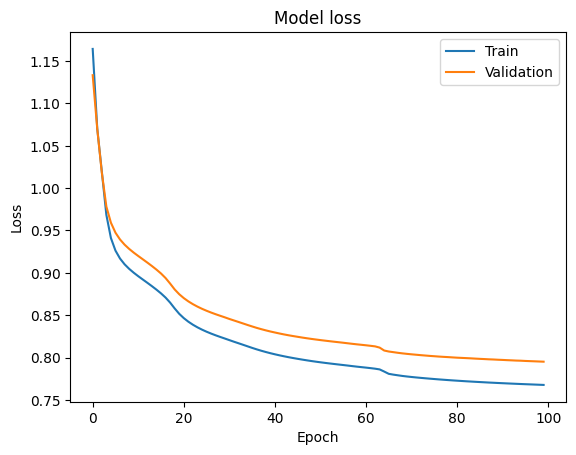

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [21]:
X_pred = autoencoder.predict(X_train)

2002/2002 [==============================] - 3s 1ms/step


In [22]:
X_pred_te = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred_te,2),axis=1)
X_pred_te.shape

870/870 [==============================] - 2s 2ms/step


(27837, 14)

In [26]:
sacar_pr_auc_mse(X_test,X_pred_te,Y_test,"autoencoder","final MSE")
sacar_pr_auc_euc(X_test,X_pred_te,Y_test,"autoencoder","final EUC")

         param   selected
0  autoencoder  final MSE
1       PR AUC   0.010908
         param   selected
0  autoencoder  final EUC
1       PR AUC   0.013121


In [27]:
prec, recall, umbral = precision_recall_curve(Y_test, ecm)

In [28]:
prec.shape, recall.shape, umbral.shape

((7725,), (7725,), (7724,))

In [29]:
prec, recall = prec[1:], recall[1:]

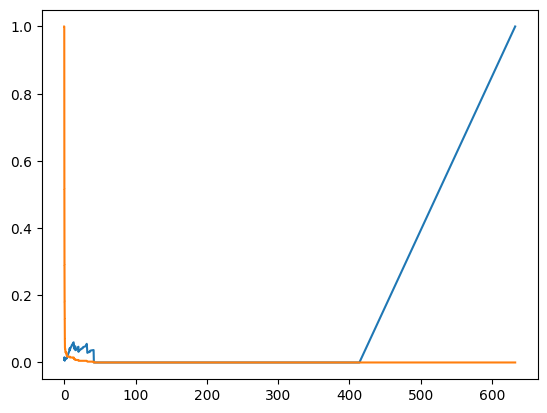

In [30]:
plt.plot(umbral, prec)
plt.plot(umbral, recall)
#plt.xlim(0,50)
plt.show()

In [49]:
umbral_fijo = 0.7
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     27434
           1       0.01      0.13      0.01       403

    accuracy                           0.71     27837
   macro avg       0.49      0.42      0.42     27837
weighted avg       0.97      0.71      0.82     27837



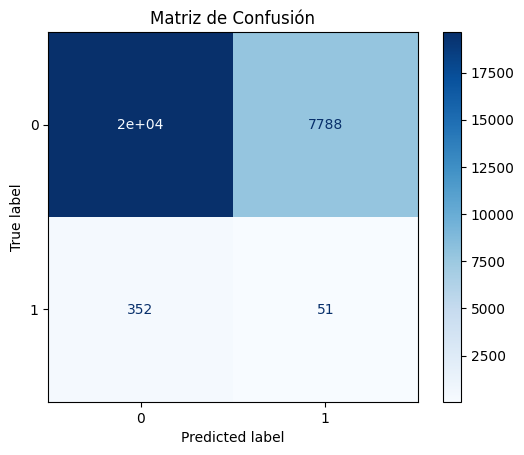

In [50]:
print_metrics(Y_test,Y_pred)
print_conf_matrix(Y_test,Y_pred)

## Etiquetado para el Challenge

In [61]:
df_autoenc_tr = make_pipeline(df_final_train)
df_autoenc_te = make_pipeline(df_final_test)

In [65]:
# CONSTRUCCIÓN DE DATOS DE TRAIN Y TEST
# =====================================
np.random.seed(6)
X_train, X_test = df_autoenc_tr, df_autoenc_te

In [63]:
index_x_train = X_train.index
index_x_test = X_test.index

In [66]:
# Train => solo los que no son fraude
# No necesita usar Y_train, ya que los datos no necesitan ir etiquetados.
# Seleccionamos los fraude=0 y luego eliminamos la columna objetivo.
X_train = X_train[X_train['fraud_flag'] == 0]
Y_train = X_train['fraud_flag']
X_train = X_train.drop(['fraud_flag'], axis=1)
X_train = X_train.values

# Test => todos
X_test = X_test.values

In [67]:
# CREAMOS LA CAPA DE ENTRADA
# =============================
dim_entrada = X_train.shape[1]
capa_entrada = Input(shape=(dim_entrada,)) # objeto keras_tensor
dim_entrada

14

In [68]:
# CREAMOS EL ENCODER
# ==================
encoder = Dense(10,activation="tanh")(capa_entrada)
encoder = Dense(7,activation="tanh")(encoder)
encoder = Dense(5,activation="tanh")(encoder)
encoder = Dense(4,activation="relu")(encoder)

In [69]:
# CREAMOS EL DECODER
# ==================
decoder = Dense(5,activation="tanh")(encoder)
decoder = Dense(7,activation="tanh")(decoder)
decoder = Dense(10,activation="tanh")(decoder)
decoder = Dense(14,activation="sigmoid")(decoder)

In [70]:
# CREAMOS EL AUTOENCODER
# =============================
autoencoder = Model(inputs=capa_entrada, outputs=decoder)

In [71]:
# CREAMOS LOS SOLVERS Y LOSS FUNCTIONS
# ====================================
# COMPILA EL AUTOENCODER CON DESCENSO DE GRADIENTE CON ALPHA 0.01 Y LOSS RMSE
sgd = SGD(lr=0.01)
#adam = Adam(lr=0.01)
autoencoder.compile(optimizer=sgd, loss="mse")

In [72]:
# ENTRENAMIENTO DEL AUTOENCODER
# =============================
nits = 100     # número de iteraciones (epochs)
tam_lote = 64  # tamaño de cada lote (batch_size)
# X_train es dato de entrada y de salida porque se trata de un autoencoder
autoencoder.fit(X_train,
                X_train, 
                epochs=nits, 
                batch_size=tam_lote,
                verbose=1)

Epoch 1/100
1430/1430 [==============================] - 3s 2ms/step - loss: 1.1546
Epoch 2/100
1430/1430 [==============================] - 2s 2ms/step - loss: 1.0465
Epoch 3/100
1430/1430 [==============================] - 3s 2ms/step - loss: 0.9991
Epoch 4/100
1430/1430 [==============================] - 3s 2ms/step - loss: 0.9681
Epoch 5/100
1430/1430 [==============================] - 2s 2ms/step - loss: 0.9463
Epoch 6/100
1430/1430 [==============================] - 2s 2ms/step - loss: 0.9312
Epoch 7/100
1430/1430 [==============================] - 2s 2ms/step - loss: 0.9198
Epoch 8/100
1430/1430 [==============================] - 2s 2ms/step - loss: 0.9105
Epoch 9/100
1430/1430 [==============================] - 3s 2ms/step - loss: 0.9020
Epoch 10/100
1430/1430 [==============================] - 3s 2ms/step - loss: 0.8933
Epoch 11/100
1430/1430 [==============================] - 2s 2ms/step - loss: 0.8753
Epoch 12/100
1430/1430 [==============================] - 2s 2ms/step - lo

In [73]:
X_pred = autoencoder.predict(X_train)

2859/2859 [==============================] - 4s 1ms/step


In [74]:
X_pred_te = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred_te,2),axis=1)
X_pred_te.shape

725/725 [==============================] - 1s 1ms/step


(23198, 14)

In [77]:
X_pred_te.shape, X_test.shape, index_x_test.shape

((23198, 14), (23198, 14), (23198,))

In [81]:
generate_output(X_pred_te, X_test, index_x_test, "Autoencoder_Final")

[0.99996134 0.99996319 0.99995753 ... 0.99995441 0.9999673  0.99995453]
   index     ID  fraud_flag
0      0  64707    0.999961
1      1  63919    0.999963
2      2  15664    0.999958
3      3   6626    0.999952
4      4  26766    0.999952
